## Read Data

In [1]:
import pandas as pd

This file was downloaded from https://www.kaggle.com/wendykan/lending-club-loan-data 

In [2]:
import os
kaggle_data = pd.read_csv(os.path.join("..", "loan.csv"), low_memory = False)

## Preliminary Transformations (don't need to be run in prediction)

Filter Loans (don't use current loans)

In [3]:
kagge_data = kaggle_data[~kaggle_data.loan_status.isin(["Current", "Does not meet the credit policy. Status:Charged Off",
                                                       "Does not meet the credit policy. Status:Fully Paid", "Issued"])]

Create target variable

In [4]:
kaggle_data = kagge_data.assign(good_loan = pd.Series(kagge_data.loan_status == "Fully Paid"))

## Split Data into Training und Validation Set

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_data, valid_data = train_test_split(kaggle_data,
                                           test_size = 0.25,
                                           random_state = 111)

## Define Target and Features 

In [7]:
target = "good_loan"
cat_features = ['home_ownership', 'purpose', 'addr_state']
num_features = ['loan_amnt', 'installment', 'annual_inc', 'int_rate', 'emp_length']
features = cat_features + num_features

In [8]:
positive_class = True

Data Types

In [9]:
kaggle_data[features].dtypes

home_ownership     object
purpose            object
addr_state         object
loan_amnt         float64
installment       float64
annual_inc        float64
int_rate          float64
emp_length         object
dtype: object

## Define Preprocessing

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

**Create Derived Features**

In [11]:
import re

In [12]:
def emp_length_num(string):
        if string == '< 1 year':
            emp_length = 0
        else:
            emp_length = find_number(string)
        return emp_length

    
    
def find_number(string):
        if type(string) is float:
            first_number = float('NaN')
        else:
            first_number = int(re.findall(pattern = '(\d+)', string = string)[0])
        return first_number
    
class CreateDerivedFeatures(TransformerMixin, BaseEstimator):
    def __init__(self):
        self

    def fit(self, X, *_):
        return self
        
    def transform(self, X, *_):
        X_transformed = X.assign(loan_income_ratio = pd.Series(X.loan_amnt / X.annual_inc),
                                 interest_income_ratio = pd.Series((X.loan_amnt * 0.01 * X.int_rate)/ X.annual_inc),
                                 emp_length = pd.Series(X.emp_length.apply(emp_length_num)))
       
        return X_transformed


In [13]:
derive_step =('derive', CreateDerivedFeatures())
derive_features = Pipeline([derive_step])

**Categorical Features**

In [14]:
si_step_cat = ('si_cat', SimpleImputer(strategy = 'constant',
                                   fill_value= 'missing_value'))
ohe_step_cat = ('ohe_cat', OneHotEncoder(handle_unknown='ignore',
                                     sparse = False))

pipe_cat = Pipeline([si_step_cat, ohe_step_cat])

**Numerical Features**

In [15]:
si_step_num = ('si_num', SimpleImputer(strategy='constant',
                                       fill_value = -999))
pipe_num = Pipeline([si_step_num])

**Preprocessing**

In [16]:
from sklearn.compose import ColumnTransformer

In [17]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', pipe_cat, cat_features),
        ('num', pipe_num, num_features)
    ])

## Define Classification Model

In [18]:
from sklearn.ensemble import RandomForestClassifier as rf

In [19]:
classifier = rf(n_estimators = 20, max_depth = 20)

## Combine Preprocessing and Classification into Pipeline

In [20]:
preprocessor_classifier = Pipeline([
    ('derive_features', derive_features),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

## Training Modell

In [21]:
fitted_model = preprocessor_classifier.fit(X = train_data[features], y = train_data[target])

## Predictions Modell

In [22]:
train_scores = fitted_model.predict_proba(X = train_data)
train_predictions = fitted_model.predict(X = train_data)
valid_scores = fitted_model.predict_proba(X = valid_data)
valid_predictions = fitted_model.predict(X = valid_data)

## Evaluation Modell

**Classifier with Parameters**

In [23]:
classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
index_positive = np.min(np.where(classifier.classes_ == positive_class))

**Feature Importance**

Here I would like to see the names of the features

In [25]:
top_n_features = 10

In [26]:
importances = fitted_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,top_n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 74 (0.312056)
2. feature 73 (0.152875)
3. feature 72 (0.147765)
4. feature 71 (0.134268)
5. feature 75 (0.072349)
6. feature 1 (0.011796)
7. feature 5 (0.009769)
8. feature 8 (0.008427)
9. feature 7 (0.007127)
10. feature 24 (0.006082)


In [27]:
import matplotlib.pyplot as plt

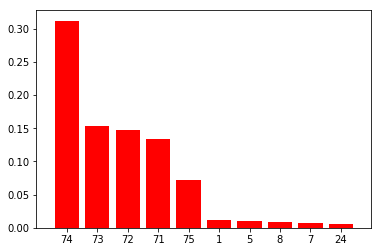

In [28]:
plt.figure()
plt.bar(range(0,top_n_features), importances[indices][0:top_n_features],
       color="r", align="center")
plt.xticks(range(0,top_n_features), indices)
plt.xlim([-1, top_n_features])
plt.show()

**Classification Report**

In [29]:
from sklearn.metrics import classification_report

Training Set

In [30]:
print(classification_report(y_true= train_data[target],
                      y_pred = train_predictions))

              precision    recall  f1-score   support

       False       0.95      0.17      0.29     50071
        True       0.79      1.00      0.88    155722

   micro avg       0.80      0.80      0.80    205793
   macro avg       0.87      0.58      0.59    205793
weighted avg       0.83      0.80      0.74    205793



Validation Set

In [31]:
print(classification_report(y_true= valid_data[target],
                      y_pred = valid_predictions))

              precision    recall  f1-score   support

       False       0.53      0.06      0.11     16597
        True       0.77      0.98      0.86     52001

   micro avg       0.76      0.76      0.76     68598
   macro avg       0.65      0.52      0.48     68598
weighted avg       0.71      0.76      0.68     68598



**Confusion Matrix**

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_true = valid_data[target],
                 y_pred = valid_predictions)

array([[  978, 15619],
       [  859, 51142]], dtype=int64)

**ROC**

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

In [35]:
roc_auc_score(y_true= valid_data[target],
              y_score = valid_scores[:,index_positive])

0.6822515070746533

In [36]:
fpr, tpr, thresholds = roc_curve(y_true= valid_data[target], y_score=valid_scores[:,index_positive])

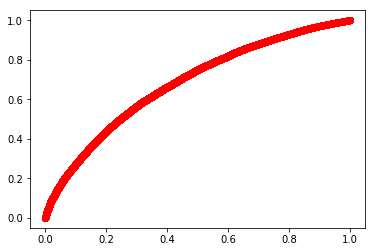

In [37]:
plt.plot(fpr, tpr, 'ro')

**Example Predictions**

In [38]:
valid_data_predictions = valid_data.assign(scores = pd.Series(valid_scores[:,index_positive]).values)

In [39]:
high_predictions = valid_data_predictions[valid_data_predictions.scores > 0.98]

In [40]:
high_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
226546,1118570,1356039,4150.0,4150.0,4150.0,36 months,7.51,129.11,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.983156
345418,21360160,23673067,2000.0,2000.0,2000.0,36 months,7.69,62.39,A,A4,...,NaN,NaN,NaN,NaN,97500.0,NaN,NaN,NaN,True,0.982720
234426,37167359,39940113,6000.0,6000.0,6000.0,36 months,6.49,183.87,A,A2,...,NaN,NaN,NaN,NaN,63800.0,NaN,NaN,NaN,True,0.983800
166676,3300520,4073310,3475.0,3475.0,3475.0,36 months,6.62,106.70,A,A2,...,NaN,NaN,NaN,NaN,162000.0,NaN,NaN,NaN,True,0.981028
212251,1351884,1596045,2725.0,2725.0,2725.0,36 months,6.03,82.94,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.980865


In [41]:
low_predictions = valid_data_predictions[valid_data_predictions.scores < 0.3]

In [42]:
low_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
793409,44865861,47943604,15100.0,15100.0,15100.0,60 months,25.80,450.32,G,G1,...,NaN,NaN,NaN,NaN,6700.0,NaN,NaN,NaN,True,0.275811
63860,8649404,10421174,13000.0,13000.0,12975.0,60 months,15.61,313.45,C,C3,...,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,True,0.299948
445085,11724917,13697068,6750.0,6750.0,6750.0,36 months,22.40,259.19,E,E3,...,NaN,NaN,NaN,NaN,15900.0,NaN,NaN,NaN,False,0.262236
25745,581198,747071,14500.0,14500.0,14475.0,60 months,21.27,394.48,G,G4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.290997
419251,13157586,15189771,10300.0,10300.0,10250.0,60 months,21.18,279.70,E,E3,...,NaN,NaN,NaN,NaN,24100.0,NaN,NaN,NaN,False,0.295699
590506,61038241,65136995,10000.0,10000.0,10000.0,60 months,19.99,264.89,E,E4,...,NaN,NaN,NaN,NaN,7300.0,NaN,NaN,NaN,False,0.288774
384137,16342957,18445374,15925.0,15925.0,15875.0,60 months,20.99,430.74,E,E4,...,NaN,NaN,NaN,NaN,24400.0,NaN,NaN,NaN,True,0.294039
270077,32419014,35032246,4825.0,4825.0,4825.0,36 months,24.50,190.57,F,F3,...,NaN,NaN,NaN,NaN,7500.0,NaN,NaN,NaN,True,0.230350
448620,11396511,13318706,5500.0,5500.0,5500.0,36 months,23.40,214.06,E,E5,...,NaN,NaN,NaN,NaN,9900.0,NaN,NaN,NaN,False,0.210644
646088,57832113,61584825,18000.0,18000.0,18000.0,60 months,24.99,528.22,F,F4,...,NaN,NaN,NaN,NaN,20800.0,NaN,NaN,NaN,False,0.278472
